In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import tifffile
import numpy as np
from utils import *
import os
from pathlib import Path
import trackpy as tp
from matplotlib.tri import Triangulation
from scipy.stats import anderson
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def take_only_walkers_on_fibre_trajectory(in_file, out_file=None):
    """Takes an input file or a stack in the form of TYXC and saves it to out file. Writes the shape of TYX"""  # I changed this to TYXC. My input has a different shape

    if isinstance(in_file, str):
        # Could also be a path object, but that would now fail. pethaps change to file exists, or test if in_file is an array
        stack = skio.imread(in_file)
    else:
        stack = in_file

    dims = stack.shape
    print(dims)
    # skip the channel?
    new_dims = (dims[0], dims[1], dims[2])
    out = np.zeros(new_dims, dtype=np.uint8)
    for i in range(dims[0]):
        frame_fibre = stack[i, :, :, 2]
        frame_walker = stack[i, :, :, 0]
        new = take_only_walkers_on_fibre(frame_fibre, frame_walker)
        out[i] = new
  
    tifffile.imwrite(
        out_file,
        out,
        ome=True,
        dtype=np.uint8,
        photometric="minisblack",
        metadata={"axes": "TYX"},
    )

In [3]:
# in_file = r"D:\data\2022-04-26_WALKER_DATA\AjasjaRollerData\25C_75mMNaCl_A8fibres\2B9\2B9_SingleMolecule_1nM_A8fibres_25C_75mMNaCl_1.tif"
# in_file = r"D:\data\2022-04-26_WALKER_DATA\AjasjaRollerData\25C_75mMNaCl_A6fibres\2B9\2B9_singlemolecule_1nM_A6fibres_25C_75mMNaCl_1.tif"
# in_file = r"D:\data\2022-04-26_WALKER_DATA\AjasjaRollerData\37C_75mMNaCl_A6fibres\2B9\2B9_singlemolecule_1nM_A6fibres_37C_75mMNaCl_NoMC_4.tif"
# in_file = r"D:\data\2022-04-26_WALKER_DATA\2021-09-27__prelim_data\2B9_SingleMolecule_1nM_A8fibres_25C_75mMNaCl_100-200.tif"
in_file = "/home/lulcakar/walker_tracker/example/20240206-114518_WT_aligned_drift_corrected.tif"

basename = os.path.basename(in_file)
out_dir = Path("./out/")
os.makedirs(out_dir, exist_ok=True)

In [4]:
take_only_walkers_on_fibre_trajectory(in_file, out_dir / basename)
basename_noext, ext = os.path.splitext(basename)

NameError: name 'take_only_walkers_on_fibre_trajectory' is not defined

In [6]:
fit_method = "lq"
box_side_length = 5
drift = 0
min_gradient = 600

In [8]:
#os.environ['HDF5_DISABLE_VERSION_CHECK']='0'
#TOOD add out parameter
!python -m picasso localize {out_dir/basename} --fit-method {fit_method} --box-side-length {box_side_length}  --gradient {min_gradient} --drift {drift}



    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           out/20240206-114518_WT_aligned_drift_corrected.tif
3        box_side_length 5         
4        fit_method      lq        
5        gradient        600       
6        drift           0         
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='localize', 

In [9]:
# Hack -- for now just rename the out file. This is dangerous in multithreaded environment.
out_locs = out_dir / (basename_noext + "_locs.hdf5")
new_suffix = f"__locs__fit_{fit_method}__box_{box_side_length}__gradient_{min_gradient}__drift_{drift}.hdf5"
new_suffix = (
    f"__locs_{fit_method}_box{box_side_length}_grad{min_gradient}_drift{drift}.hdf5"
)
new_out_locs = out_dir / (basename_noext + new_suffix)
print(new_out_locs)
out_locs.with_suffix(".yaml").rename(new_out_locs.with_suffix(".yaml"))
out_locs.rename(new_out_locs)

out/20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5


PosixPath('out/20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5')

In [2]:
new_out_locs = Path('out/20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5')

In [3]:
max_link_displacement_px = 2
min_tray_length = 3

In [34]:
locs = pd.read_hdf(new_out_locs, "locs")
locs["mass"] = locs.photons

tray = tp.link(locs, max_link_displacement_px)

# count the length of trajectories
tray_by_particle = tray.groupby(["particle"])
tray["length"] = tray_by_particle["particle"].transform("count")

print("mean drift ", tp.compute_drift(tray).mean())

# Exclude very short trays
tray = tray.query(f"length>={min_tray_length}")

steps = tray.groupby(["particle"]).apply(get_steps_from_df)
steps["step_len"] = np.sqrt(steps.dx**2 + steps.dy**2)

suffix = f"__link{max_link_displacement_px}_traylen{min_tray_length}"
base_linked_tray = Path(f'{new_out_locs.with_suffix("")}{suffix}')
tray_out = base_linked_tray.with_suffix(".tray.csv.gz")
tray.to_csv(tray_out)
steps_out = base_linked_tray.with_suffix(".steps.csv.gz")
steps.to_csv(steps_out)

#distribution_check = []
steps_matrix = steps[['dx', 'dy']].to_numpy()
num_columns = steps_matrix.shape[1]  
normal_str = ''
for var_idx in range(num_columns):
    anderson_data = anderson(steps_matrix[:, var_idx])
    is_normal = anderson_data.statistic < anderson_data.critical_values[1]
    #distribution_check += [is_normal]
    if not is_normal:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} NOT normally distributed at {anderson_data.significance_level[1]}%\n"
    else:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} normally distributed at {anderson_data.significance_level[1]}%\n"
    normal_str += normal 

info = {}
info["diff_1D_px_px_frame"] = float(get_diff_from_steps(steps))

px_to_nm = 110
frame_to_s = 0.665

info["diff_1D_nm_nm_s"] = (
    info["diff_1D_px_px_frame"] * px_to_nm * px_to_nm / frame_to_s
)
info["time_per_1000nm_s"] = 1000 * 1000 / info["diff_1D_nm_nm_s"] / 2

info["mean_step_nm_s"] = float(
    np.sqrt(2 * info["diff_1D_nm_nm_s"] * frame_to_s) / frame_to_s
)

diff_info_out = base_linked_tray.with_suffix(".diff")

info["normality_str"] = normal_str
info["anderson_test"] = anderson_data

write_yaml(info, diff_info_out)


Frame 9713: 14 trajectories present.
mean drift  y   -23.804871
x    11.581981
dtype: float32


In [5]:
x = steps['dx'].to_numpy()
y = steps['dy'].to_numpy()
hist, xedges, yedges = np.histogram2d(x, y, bins=75)

class MultivariateNormal(object):
    def __init__(self):
        self.u_ = None
        self.sig_ = None
    @staticmethod
    def redimx(x): return x[...,np.newaxis] if x.ndim == 2 else x
    def fit(self, x):
        x = self.redimx(x)
        self.u_ = x.mean(0)
        self.sig_ = np.einsum('ijk,ikj->jk', x-self.u_, x-self.u_)/ (x.shape[0]-1)
    def prob(self, x):
        x = self.redimx(x)
        f1 = (2*np.pi)**(-self.u_.shape[0]/2)*np.linalg.det(self.sig_)**(-1/2)
        f2 = np.exp((-1/2)*np.einsum('ijk,jl,ilk->ik', x-self.u_, np.linalg.inv(self.sig_), x-self.u_))
        return f1*f2

variable dx NOT normally distributed at 10.0%
variable dy NOT normally distributed at 10.0%

the means of multivariate normal distrubution are: mu(dx) = 0.002, mu(dy) = -0.003
the standard deviations of the multivariate normal distribution are: sigma(dx) = 0.421, sigma(dy) = 0.317
the covariance of the multivariate normal distribution is: sigma(dxdy) = 0.031
Diff (in px^2/frame):  0.3689572513103485
Diff (in nm^2/s):  6713.357505045438
time per 1000nm (s):  74.47838129046814
mean step (nm/s): 142.0934512472503


Text(0.5, 0.92, 'Probability density of step sizes - surface plot')

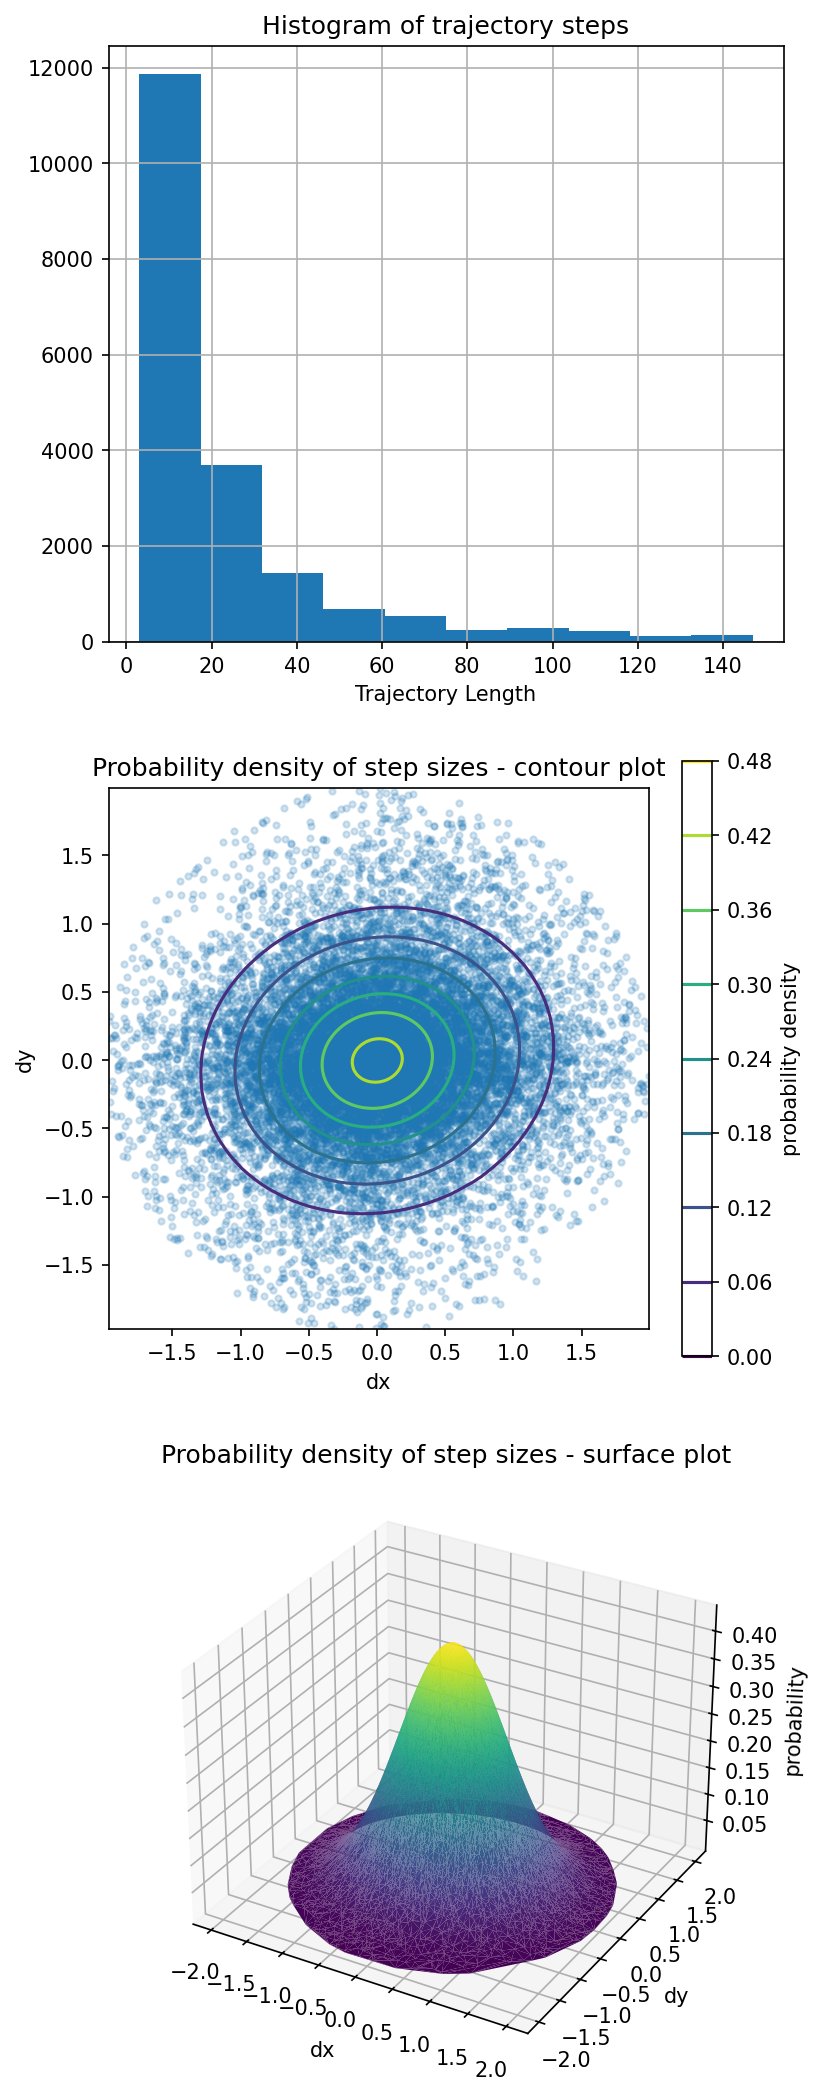

In [35]:
mod = MultivariateNormal()
mod.fit(steps_matrix)
print(normal_str)
print(f'the means of multivariate normal distrubution are: mu(dx) = {mod.u_[0][0]:.3f}, mu(dy) = {mod.u_[1][0]:.3f}')
print(f'the standard deviations of the multivariate normal distribution are: sigma(dx) = {mod.sig_[0][0]:.3f}, sigma(dy) = {mod.sig_[1][1]:.3f}')
print(f'the covariance of the multivariate normal distribution is: sigma(dxdy) = {mod.sig_[0][1]:.3f}')
print("Diff (in px^2/frame): ", info["diff_1D_px_px_frame"])
print("Diff (in nm^2/s): ", info["diff_1D_nm_nm_s"])
print("time per 1000nm (s): ", info["time_per_1000nm_s"])
print("mean step (nm/s):", info["mean_step_nm_s"])


z = mod.prob(steps_matrix)
triang = Triangulation(x, y)
fig = plt.figure(figsize=(5,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
#ax3 = fig.add_subplot(313)
ax3 = fig.add_subplot(313, projection='3d')
fig.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0) 
plt.sca(ax1)
tray.length.hist()
plt.xlabel("Trajectory Length")
plt.title("Histogram of trajectory steps")
#plt.sca(ax2)
#steps.plot.scatter("dx", "dy", alpha=0.1, ax=ax2)
#plt.title("Size of steps")
plt.sca(ax2)
plt.plot(x,y, '.', alpha = 0.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.tricontour(triang, z.ravel(), cmap = 'viridis')
plt.colorbar(label='probability density') 
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('Probability density of step sizes - contour plot')
plt.sca(ax3)
ax3.plot_trisurf(triang, z.ravel(), cmap='viridis')
plt.xlabel('dx')
plt.ylabel('dy')
ax3.set_zlabel('probability')
plt.title('Probability density of step sizes - surface plot')
